# Machine Learning on Seismic Data (Classification & Clustering)

In this notebook, I apply basic machine learning methods on real seismic waveform data.  
This builds on the previous analysis (Notebook 9), where I used STA/LTA to detect seismic events.

## Objectives:
- Classify seismic windows as **'event'** or **'no-event'**
- Cluster similar waveform segments to identify patterns

## Approach:
- Retrieve waveform data from the **IRIS database**
- Apply **STA/LTA** for initial event detection
- Extract features from time-domain windows
- Use **Logistic Regression** (Supervised) to classify events
- Use **KMeans Clustering** (Unsupervised) to discover hidden structures

## Additionally,

To enhance the model robustness, I applied a **Random Forest Classifier**. This ensemble method tends to perform better with small noisy datasets and also provides feature importance, helping interpret which seismic characteristics most contribute to event detection.

I applied   
**DBSCAN**, a clustering method that can identify dense regions in the data while marking outliers as noise. This technique is useful for detecting **unusual seismic events** that may not fit into traditional event/no-event categories.  

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) is a powerful dimensionality reduction technique that is excellent for visualizing high-dimensional seismic data. It helps us uncover potential patterns or clusters that might not be immediately obvious in the original space.

### Anomaly Detection: Autoencoders

In this section, I trained an **autoencoder**, a neural network that learns a compressed representation of seismic data. The reconstruction error is then used to identify **anomalous seismic events** that might be rare but significant.

This notebook demonstrates how signal processing and basic ML techniques can be combined to automate event detection in seismic time-series data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
#using same station data from previous notebook 9 
client = Client("IRIS")
starttime = UTCDateTime("2010-02-27T06:30:00")
endtime = starttime + 10 * 60  # 10 minutes

st = client.get_waveforms(network="IU", station="ANMO", location="00", channel="BHZ",
                          starttime=starttime, endtime=endtime)

st.detrend("linear")
st.filter("bandpass", freqmin=0.5, freqmax=5.0)

tr = st[0]

#Short-Term Average / Long-Term Average (STA/LTA) is used to detect sudden increases in amplitude, which may indicate seismic events.

# to detect events
nsta = int(1 * tr.stats.sampling_rate)
nlta = int(20 * tr.stats.sampling_rate)

cft = classic_sta_lta(tr.data, nsta, nlta)
on_thresh, off_thresh = 3.5, 0.5
trig_onsets = trigger_onset(cft, on_thresh, off_thresh)



## 3. Feature Engineering

We break the waveform into overlapping windows and extract features like:
- Mean
- Standard Deviation
- Max, Min
- Energy
- Zero Crossings

Each window is labeled as 1 (event) or 0 (no-event) based on STA/LTA triggers.


In [3]:
#Slicing the window and feature extraction
window_size = int(10 * tr.stats.sampling_rate)  # 10-second windows
step_size = int(5 * tr.stats.sampling_rate)     # 5-second step

features = []
labels = []

for start in range(0, len(tr.data) - window_size, step_size):
    window = tr.data[start:start + window_size]
    timeslice = tr.times()[start:start + window_size]
    
    # Extract simple features
    feat = [
        np.mean(window),
        np.std(window),
        np.max(window),
        np.min(window),
        np.sum(window**2),                  # energy
        np.count_nonzero(np.diff(np.sign(window)))  # zero crossings
    ]
    
    features.append(feat)
    
    # Label as event (1) if this window overlaps a detected event
    label = 0
    for onset in trig_onsets:
        if onset[0] < start + window_size and onset[1] > start:
            label = 1
            break
    labels.append(label)

X = np.array(features)
y = np.array(labels)


## Machine Learning on Seismic Data

In this section, I explored the use of basic machine learning models to identify patterns in seismic data.

- **Supervised Learning (Classification)**: I used a classifier to learn from labeled seismic signals and predict whether a signal is an earthquake or noise. This method relies on historical data with known outcomes.

- **Unsupervised Learning (Clustering)**: Using KMeans clustering, I grouped similar seismic signals without any labels. This technique helps uncover hidden patterns or new types of seismic events.

These visualizations help demonstrate how machine learning can assist in analyzing and automating seismic event detection.

**Classification**  
training a sample classifier

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.73      0.73      0.73        11

    accuracy                           0.83        36
   macro avg       0.80      0.80      0.80        36
weighted avg       0.83      0.83      0.83        36

[[22  3]
 [ 3  8]]


C:\Users\saijy\conda\envs\seismic_env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


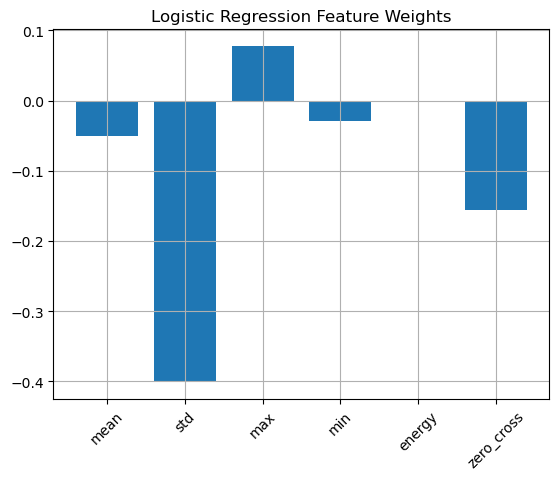

In [5]:
#visualising (Rudimentary)
plt.bar(range(len(clf.coef_[0])), clf.coef_[0])
plt.xticks(range(len(clf.coef_[0])), ['mean', 'std', 'max', 'min', 'energy', 'zero_cross'], rotation=45)
plt.title("Logistic Regression Feature Weights")
plt.grid(True)
plt.show()


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        25
           1       0.67      0.73      0.70        11

    accuracy                           0.81        36
   macro avg       0.77      0.78      0.78        36
weighted avg       0.81      0.81      0.81        36

Confusion Matrix:
[[21  4]
 [ 3  8]]


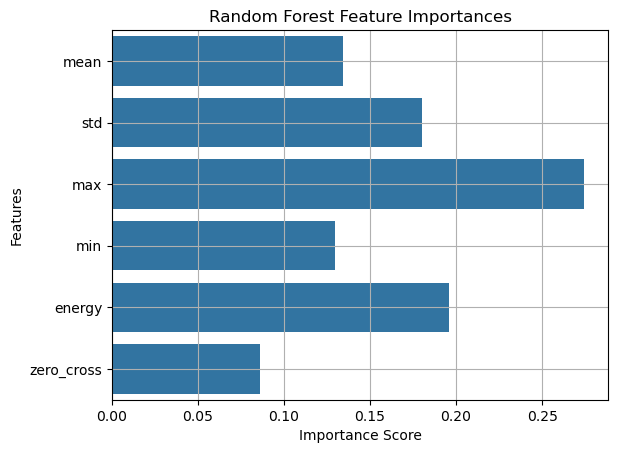

In [7]:
# Feature importance plot
import seaborn as sns

feature_names = ['mean', 'std', 'max', 'min', 'energy', 'zero_cross']
importances = rf_clf.feature_importances_

sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.show()


**Clustering (Unsupervisied)**

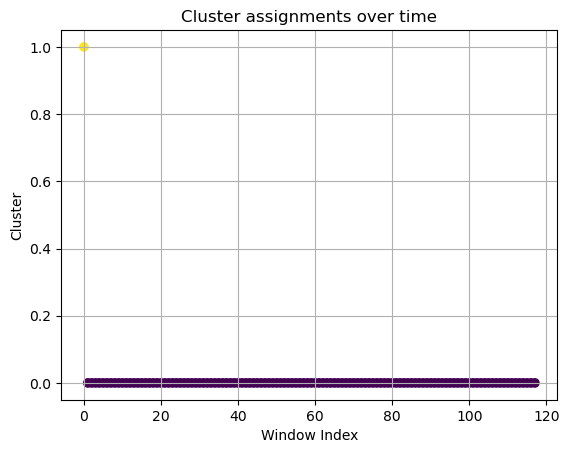

In [8]:
#KMeans is applied on the features (without labels) to group similar waveform segments. This may help reveal hidden patterns.
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(X)

# Compare cluster assignment with labels
plt.scatter(range(len(clusters)), clusters, c=clusters, cmap='viridis', label='Cluster ID')
plt.title("Cluster assignments over time")
plt.xlabel("Window Index")
plt.ylabel("Cluster")
plt.grid(True)
plt.show()


### Unsupervised Clustering: DBSCAN (Density-Based Spatial Clustering)


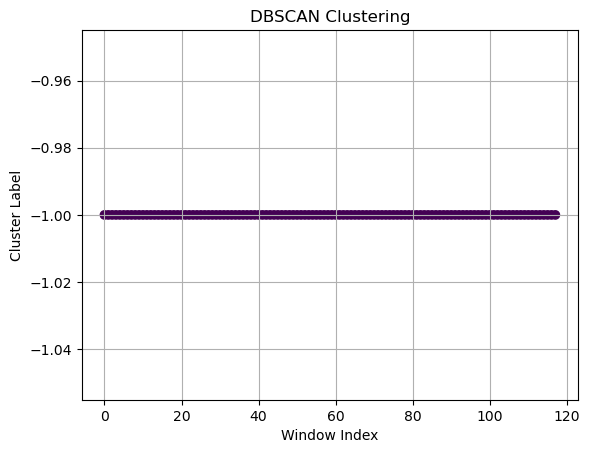

In [9]:
from sklearn.cluster import DBSCAN

# Applying DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Visualize the clustering results
plt.scatter(range(len(dbscan_labels)), dbscan_labels, c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clustering")
plt.xlabel("Window Index")
plt.ylabel("Cluster Label")
plt.grid(True)
plt.show()


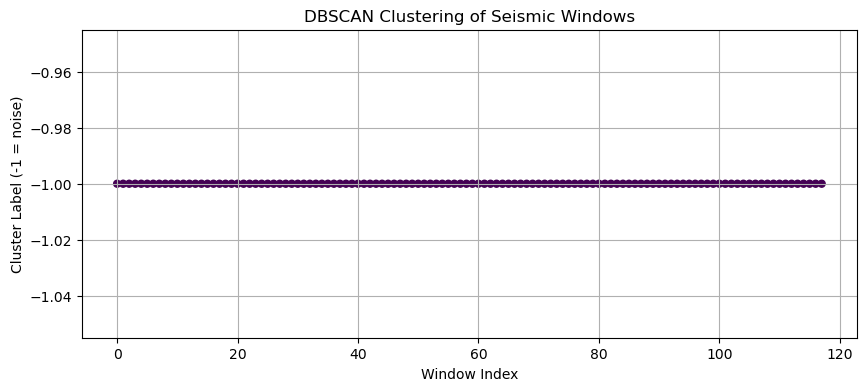

In [13]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Applying DBSCAN to the seismic features with more precise visualization
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Feel free to tune eps/min_samples
dbscan_labels = dbscan.fit_predict(X)

# Visualize clustering results
plt.figure(figsize=(10, 4))
plt.scatter(range(len(dbscan_labels)), dbscan_labels, c=dbscan_labels, cmap='viridis', s=25)
plt.title("DBSCAN Clustering of Seismic Windows")
plt.xlabel("Window Index")
plt.ylabel("Cluster Label (-1 = noise)")
plt.grid(True)
plt.show()


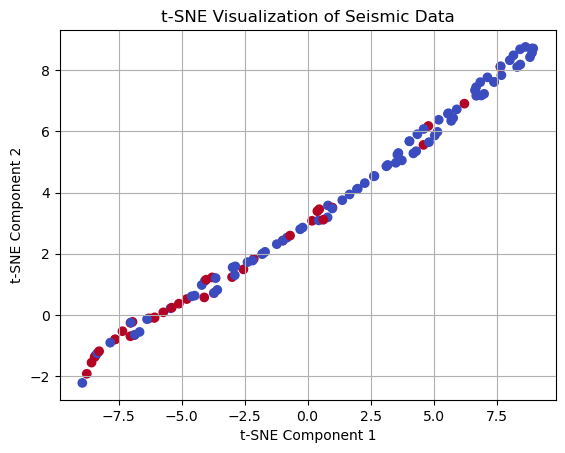

In [10]:
from sklearn.manifold import TSNE

# Reduce the dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualize t-SNE results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm')
plt.title("t-SNE Visualization of Seismic Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 78231822336.0000
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 128835297280.0000 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 128173629440.0000 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78305001472.0000
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78796259328.0000 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 52891582464.0000
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 78116765696.0000
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35934740480.0000
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 53283409920.0000
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78097948672.0000
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 128592035840.0000 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 78727741440.0000 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52922109952.0000
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 

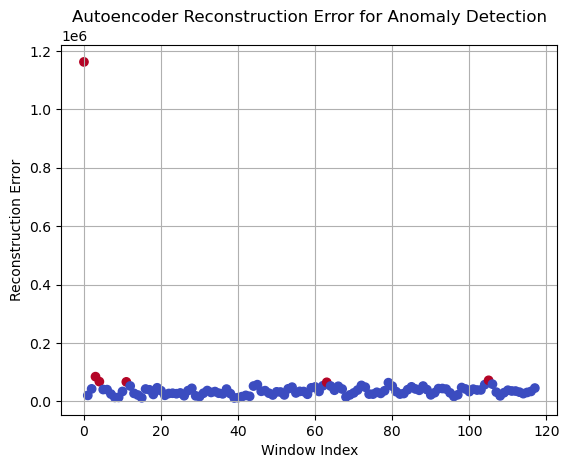

In [11]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

# Autoencoder architecture
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(5, activation='relu')(input_layer)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=32, shuffle=True)

# Use reconstruction error to detect anomalies
reconstructed = autoencoder.predict(X)
reconstruction_error = np.mean(np.abs(X - reconstructed), axis=1)

# Threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Visualize the anomalies
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=anomalies, cmap='coolwarm')
plt.title("Autoencoder Reconstruction Error for Anomaly Detection")
plt.xlabel("Window Index")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.show()
